ARCUS: Automated Research and Creation of Use case Solutions

In [20]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os

load_dotenv()
os.environ["LANGCHAIN_PROJECT"] = "ARCUS"

In [21]:
llm = ChatGroq(model="llama-3.1-8b-instant")
print(llm.invoke('Hi').content)

It's nice to meet you. Is there something I can help you with or would you like to chat?


In [22]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph import MessagesState
from langgraph.checkpoint.memory import MemorySaver

generate_company_information_prompt="""
You are tasked with extracting the company's information. Name of the company and Industry of the company.
"""

def generate_co_info(state: MessagesState):
    return {"messages": [llm.invoke([generate_company_information_prompt] + state["messages"])]}

In [23]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState
from pydantic import BaseModel, Field

class ARCUSState(MessagesState):
    context: Annotated[list, operator.add]
    result: str
    research: str
    use_case: str
    use_case_list: list
    resources: str
    report: str

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [24]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader
from langchain_core.messages import get_buffer_string

In [25]:
tavily_search = TavilySearchResults(max_results=3)

In [26]:
search_instructions = SystemMessage(content=f"""
You will be given a company information.

Your goal is to generate a well-structured query for use in retrieval and/or web-search related to the company.

The search results must identify the company's key offerings and strategic focus areas (e.g., operations, supply chain, customer experience, etc.). A vision and product information on the industry should be fine as well.
Refer to reports and insights on AI and digital transformation from industry-specific sources such as McKinsey, Deloitte, or Nexocode.

Convert this into a well-structured web-search query.
""")

def search_web(state: ARCUSState):
    """Retrieve docs from web search"""

    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    search_docs = tavily_search.invoke(search_query.search_query)

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f"<Document href='{doc["url"]}'/>\n{doc["content"]}\n/Document>" for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wiki(state: ARCUSState):
    """Retrieve docs from wikipedia"""

    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    search_docs = WikipediaLoader(query=search_query.search_query, load_max_docs=2).load()

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f"<Document source='{doc.metadata["source"]}' page='{doc.metadata.get("page", "")}'/>\n{doc.page_content}\n/Document>" for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def save_result(state: ARCUSState):
    """Save result"""
    messages = state['messages']

    result = get_buffer_string(messages)

    return {"result": result}

In [27]:
research_writer_instructions = """You are an expert technical writer.

Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

5. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

6.Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed
"""

def write_research(state: ARCUSState):
    """Node to write the research"""
    context = state['context']

    system_message = research_writer_instructions
    research = llm.invoke([SystemMessage(content=system_message)] + [HumanMessage(content=f"Use this source to write your research report: {context}")])

    return {"research": [research.content]}


In [28]:
import ast

prompt_uc="""
Based on the market research conducted:
1. Analyze industry trends and standards within the company's sector related to AI, ML, and automation.
2. Propose relevant use cases where the company can leverage GenAI, LLMs, and ML technologies to improve their processes, enhance customer satisfaction, and boost operational efficiency.

And also in the end of your response give a list of use_cases as a summary,
eg. use_case = ['use_case1', 'use_case2',...]

Here is the market research summary:

{research_summary}
"""

def use_case_generator(state: ARCUSState):
    "Node to generate use cases"
    research = state['research']

    formatted_str_research = "\n\n".join([f"{rs}" for rs in research])

    system_message = prompt_uc.format(research_summary=formatted_str_research)

    use_case_x = llm.invoke([SystemMessage(content=system_message)])

    start_index = use_case_x.content.find("use_cases = [")
    if start_index != -1:
        list_str = use_case_x.content[start_index + len("use_cases = "):].strip()
        use_cases = ast.literal_eval(list_str)

    return {'use_case': use_case_x.content, 'use_case_list': use_cases}

In [29]:
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools import ArxivQueryRun

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)

tools = []
llm_with_tools = llm.bind(tools=tools)

In [30]:
from langgraph.prebuilt import ToolNode

In [31]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

def resource_collector(state: ARCUSState):
    use_cases = state['use_case_list']

    # Not employing tools to get dataset, using kaggle API, seriealizer error is coming while using arxiv tool, hence skipped.

    ds_links = {}
    for use_case_x in use_cases:
        datasets = api.dataset_list(search=use_case_x)
        datasets = datasets[:5]

        full_urls = ["https://www.kaggle.com/datasets/" + dataset.ref for dataset in datasets]

        ds_links[use_case_x] = full_urls

    fr_prompt = "Your job is to collect resources according to use-cases and organize the resources and datasets properly in a markdown format"

    resources = llm.invoke([SystemMessage(content=fr_prompt)] + [HumanMessage(content=f"Here are dataset links fetched from API:\n{ds_links}")])
    return {"resources": resources.content}

In [32]:
report_instructions = """
Generate a professional report in markdown format based on the provided data. Ensure proper formatting, clickable links, and clear structure. Follow the instructions below carefully:

## Report Structure:
1. **Heading**: Replace `XYZ` with the company name. The heading format should be:
   ```
   # GenAI & ML Use Case for XYZ
   ```
2. **Executive Summary**: Summarize key insights such as the company's background, competitors, market research, or history.
   - Use clear and concise bullet points.
   - Ensure placeholders like `(About/History/Competitors/Market Research)` are replaced with actual content.

3. **Use Case Descriptions**: Include detailed descriptions of each use case with the following format:
   ```
   ## Use Case Descriptions
   - **Use Case 1: (Descriptive Name)**
       - Objective/Use Case: ...
       - AI Application: ...
       - Cross-Functional Benefit:
           - Point 1
           - Point 2
           - Point 3 (Add more as needed)
   - **Use Case 2: (Descriptive Name)**
       - Objective/Use Case: ...
       - AI Application: ...
       - Cross-Functional Benefit:
           - Point 1
           - Point 2
           - Point 3
   ```

4. **Key Resources**: Create a section titled `## Key Resources`. Include all provided resource links in a clickable format.

5. **Sources**: Compile and list all sources under the `## Sources` section. Ensure:
   - Each source is unique and listed on a new line.
   - Sources are ordered as referenced in the text.
   - No duplicates are included.
   - Don't use dataset links in source citation.

## Markdown and Formatting Guidelines:
- Use markdown syntax for headings, bullet points, and links.
- Use -------- separator wherever necessary.
- The final markdown file must look good.
- Do not use tables.
- Ensure all dataset/resource links are clickable.
- Avoid including the `use_cases` list directly in the Executive Summary.
- Preserve inline citations in the format `[1]`, `[2]`, etc.

## Input Data:
Here is the data you need to use:

### Company Information:
{info}

### Use Cases:
{use_case}

### Resource Links:
{resources}

### Market Research:
{research}
"""

def write_report(state: ARCUSState):
    resources = state['resources']
    use_case = state['use_case']
    research = state['research']
    info = state['messages'][1].content

    sys_msg = report_instructions.format(use_case=use_case, resources=resources, research=research, info=info)

    report = llm.invoke([SystemMessage(content=sys_msg)])

    return {"report": report.content}

In [33]:
def tools_condition_custom(state: ARCUSState):
    messages = state['messages']
    ai_message = messages[-1]

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "write_report"

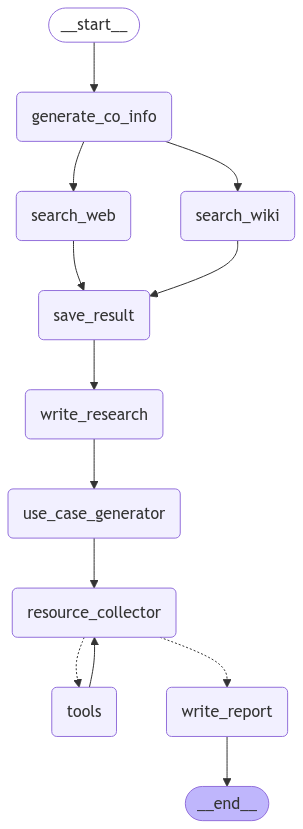

In [34]:
arcus_builder = StateGraph(ARCUSState)
arcus_builder.add_node("generate_co_info", generate_co_info)
arcus_builder.add_node("search_web", search_web)
arcus_builder.add_node("search_wiki", search_wiki)
arcus_builder.add_node("save_result", save_result)
arcus_builder.add_node("write_research", write_research)
arcus_builder.add_node("use_case_generator", use_case_generator)
arcus_builder.add_node("resource_collector", resource_collector)
tool_node = ToolNode(tools=tools)
arcus_builder.add_node("tools", tool_node)
arcus_builder.add_node("write_report", write_report)

arcus_builder.add_edge(START, "generate_co_info")
arcus_builder.add_edge("generate_co_info", "search_web")
arcus_builder.add_edge("generate_co_info", "search_wiki")
arcus_builder.add_edge("search_web", "save_result")
arcus_builder.add_edge("search_wiki", "save_result")
arcus_builder.add_edge("save_result", "write_research")
arcus_builder.add_edge("write_research", "use_case_generator")
arcus_builder.add_edge("use_case_generator", "resource_collector")
arcus_builder.add_conditional_edges(
    "resource_collector",
    tools_condition_custom,
    {
        "tools": "tools",
        "write_report": "write_report",
    }
)
arcus_builder.add_edge("tools", "resource_collector")
arcus_builder.add_edge("write_report", END)


memory = MemorySaver()
arcus_graph = arcus_builder.compile(checkpointer=memory)

display(Image(arcus_graph.get_graph(xray=1).draw_mermaid_png()))

In [35]:
company_name = "Tesla"
messages = [HumanMessage(f" Company Name: {company_name}")]
thread = {"configurable": {"thread_id": "2"}}
research = arcus_graph.invoke({"messages": messages}, thread)

In [36]:
from IPython.display import Markdown

research['messages'][1].content

'Based on the company name "Tesla", I was able to extract the following information:\n\n1. **Company Name:** Tesla, Inc.\n2. **Industry:** \n   - Automotive (Electric Vehicles)\n   - Clean Energy\n   - Technology (Energy Storage, Renewable Energy)'

In [37]:
Markdown(research['report'])

# GenAI & ML Use Case for Tesla

## Executive Summary
Tesla, Inc. is a pioneering electric vehicle manufacturer, clean energy provider, and technology company. The company has been at the forefront of digital transformation, integrating artificial intelligence (AI) and machine learning (ML) into its products and manufacturing processes. The industry is witnessing significant advancements in AI, ML, and automation, driven by increasing consumer demand and government incentives for sustainable energy.

### Market Research
*   Tesla's strategic focus has shifted towards the development of affordable vehicles, cost reductions, and the integration of AI into its products.
*   The company has been at the forefront of digital transformation, leveraging digital technologies to enhance manufacturing efficiency, customer engagement, and technological leadership.
*   Tesla's product portfolio and case strategies report highlights the company's networked energy approach, which has given rise to a new industry and will drive exponential growth.

### Industry Trends and Standards Analysis

Based on the market research, Tesla's sector is experiencing significant advancements in AI, ML, and automation. Key industry trends and standards include:

*   **Electric Vehicle (EV) Adoption:** EVs are gaining popularity, driven by increasing consumer demand and government incentives for sustainable energy.
*   **AI and Automation:** Companies like Tesla are integrating AI and automation into their products and manufacturing processes to improve efficiency, reduce costs, and enhance customer experience.
*   **Digital Transformation:** The use of digital technologies, such as IoT, blockchain, and ML, is becoming increasingly prevalent in the automotive industry.
*   **Cybersecurity:** As vehicles become more connected, cybersecurity risks are rising, requiring companies to invest in robust security measures.

## Use Case Descriptions

### Use Case 1: Predictive Maintenance

*   **Objective/Use Case:** Predictive maintenance is a process that uses historical data and real-time sensor data to predict when equipment is likely to fail. This allows for proactive maintenance, reducing downtime and improving overall manufacturing efficiency.
*   **AI Application:** ML algorithms can be used to analyze historical data and predict equipment failures. This can be done by using techniques such as regression analysis, decision trees, and neural networks.
*   **Cross-Functional Benefit:**
    *   Reduced downtime and improved manufacturing efficiency.
    *   Improved product quality and reduced defects.
    *   Increased customer satisfaction through improved delivery times and reduced wait times.

### Use Case 2: Customer Sentiment Analysis

*   **Objective/Use Case:** Customer sentiment analysis is a process that uses natural language processing (NLP) and machine learning to analyze customer feedback and sentiment. This allows for data-driven product development and improvement.
*   **AI Application:** LLMs can be used to analyze customer feedback and sentiment. This can be done by using techniques such as sentiment analysis, topic modeling, and clustering.
*   **Cross-Functional Benefit:**
    *   Improved customer satisfaction through data-driven product development and improvement.
    *   Increased customer loyalty and retention.
    *   Improved brand reputation through better understanding of customer needs and preferences.

### Use Case 3: Supply Chain Optimization

*   **Objective/Use Case:** Supply chain optimization is a process that uses data analytics and machine learning to optimize supply chain operations, reducing costs and improving delivery times.
*   **AI Application:** AI and ML can be used to analyze supply chain data and predict demand, optimize inventory levels, and route delivery trucks more efficiently.
*   **Cross-Functional Benefit:**
    *   Reduced costs through optimized supply chain operations.
    *   Improved delivery times and reduced wait times.
    *   Increased customer satisfaction through improved delivery times and reduced wait times.

### Use Case 4: Autonomous Driving

*   **Objective/Use Case:** Autonomous driving is a process that uses AI and ML to enable vehicles to drive themselves, improving safety and reducing accident risks.
*   **AI Application:** LLMs can be used to analyze sensor data and make decisions about steering, acceleration, and braking.
*   **Cross-Functional Benefit:**
    *   Improved safety through reduced accident risks.
    *   Increased mobility for the elderly and disabled.
    *   Reduced traffic congestion and improved air quality.

### Use Case 5: Energy Efficiency

*   **Objective/Use Case:** Energy efficiency is a process that uses data analytics and machine learning to optimize energy consumption, reducing waste and improving overall efficiency.
*   **AI Application:** ML algorithms can be used to analyze energy consumption data and predict energy usage patterns.
*   **Cross-Functional Benefit:**
    *   Reduced energy consumption and waste.
    *   Improved overall efficiency and productivity.
    *   Increased customer satisfaction through reduced energy costs.

### Use Case 6: Chatbots and Virtual Assistants

*   **Objective/Use Case:** Chatbots and virtual assistants are a process that uses AI and ML to enable customers to interact with companies through chat interfaces, improving customer engagement and support.
*   **AI Application:** LLMs can be used to analyze customer queries and provide personalized responses.
*   **Cross-Functional Benefit:**
    *   Improved customer engagement and support.
    *   Increased customer satisfaction through personalized responses.
    *   Reduced customer support costs through automation.

### Use Case 7: Quality Control

*   **Objective/Use Case:** Quality control is a process that uses data analytics and machine learning to identify defects and improve product quality.
*   **AI Application:** ML algorithms can be used to analyze product data and predict defects.
*   **Cross-Functional Benefit:**
    *   Improved product quality and reduced defects.
    *   Reduced waste and improved overall efficiency.
    *   Increased customer satisfaction through improved product quality.

### Use Case 8: Predictive Analytics

*   **Objective/Use Case:** Predictive analytics is a process that uses data analytics and machine learning to predict market trends, customer behavior, and product demand.
*   **AI Application:** ML algorithms can be used to analyze data and predict trends and behavior.
*   **Cross-Functional Benefit:**
    *   Improved data-driven decision making.
    *   Increased customer satisfaction through personalized recommendations.
    *   Improved brand reputation through better understanding of customer needs and preferences.

## Key Resources

### Dataset Collection and Organization

*   **Predictive Maintenance:** https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification
*   **Customer Sentiment Analysis:** https://www.kaggle.com/datasets/niraliivaghani/flipkart-product-customer-reviews-dataset
*   **Supply Chain Optimization:** https://www.kaggle.com/datasets/dorothyjoel/us-regional-sales
*   **Autonomous Driving:** https://www.kaggle.com/datasets/usharengaraju/pandaset-dataset
*   **Energy Efficiency:** https://www.kaggle.com/datasets/elikplim/eergy-efficiency-dataset
*   **Chatbots and Virtual Assistants:** https://www.kaggle.com/datasets/kreeshrajani/3k-conversations-dataset-for-chatbot
*   **Quality Control:** https://www.kaggle.com/datasets/concaption/pepsico-lab-potato-quality-control
*   **Predictive Analytics:** https://www.kaggle.com/datasets/priyamchoksi/100000-diabetes-clinical-dataset

## Sources

[1] https://www.morningstar.com/company-reports/1258674-teslas-strategic-focus-shifts-to-development-of-affordable-vehicles-cost-reductions-and-ai
[2] https://www.prnewswire.com/news-releases/tesla-product-portfolio-and-case-strategies-report-2020-2025-teslas-networked-energy-approach-has-given-rise-to-a-new-industry-and-will-drive-exponential-growth-301304402.html
[3] https://www.linkedin.com/pulse/driving-innovation-deep-dive-teslas-digital-sushil-rathee-ntakc
[4] https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification
[5] https://www.kaggle.com/datasets/niraliivaghani/flipkart-product-customer-reviews-dataset
[6] https://www.kaggle.com/datasets/dorothyjoel/us-regional-sales
[7] https://www.kaggle.com/datasets/usharengaraju/pandaset-dataset
[8] https://www.kaggle.com/datasets/elikplim/eergy-efficiency-dataset
[9] https://www.kaggle.com/datasets/kreeshrajani/3k-conversations-dataset-for-chatbot
[10] https://www.kaggle.com/datasets/concaption/pepsico-lab-potato-quality-control
[11] https://www.kaggle.com/datasets/priyamchoksi/100000-diabetes-clinical-dataset

In [40]:
file_path = f"ARCUS_{company_name}.md"

# Exporting the markdown text to a file
with open(file_path, "w") as file:
    file.write(research['report'])

print(f"Markdown file saved at: {file_path}")

Markdown file saved at: ARCUS_Tesla.md


In [42]:
Markdown(research['resources'])

**Dataset Collection and Organization**
=====================================

Below is a well-structured markdown format for organizing the dataset links according to use-cases. The datasets are grouped into eight categories: Predictive Maintenance, Customer Sentiment Analysis, Supply Chain Optimization, Autonomous Driving, Energy Efficiency, Chatbots and Virtual Assistants, Quality Control, and Predictive Analytics.

**1. Predictive Maintenance**
-----------------------------

*   **Machine Predictive Maintenance Classification**: https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification
*   **Microsoft Azure Predictive Maintenance**: https://www.kaggle.com/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance
*   **Predictive Maintenance Dataset AI4I 2020**: https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020
*   **Preventive to Predictive Maintenance**: https://www.kaggle.com/datasets/prognosticshse/preventive-to-predicitve-maintenance
*   **Predictive Maintenance Dataset**: https://www.kaggle.com/datasets/hiimanshuagarwal/predictive-maintenance-dataset

**2. Customer Sentiment Analysis**
---------------------------------

*   **Flipkart Product Customer Reviews Dataset**: https://www.kaggle.com/datasets/niraliivaghani/flipkart-product-customer-reviews-dataset
*   **Product Reviews Dataset for Sentiment Analysis**: https://www.kaggle.com/datasets/burhanbilenn/duygu-analizi-icin-urun-yorumlari
*   **Customer Feedback Dataset**: https://www.kaggle.com/datasets/vishweshsalodkar/customer-feedback-dataset
*   **Women's E-commerce Clothing Reviews**: https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews
*   **Emotion Dataset**: https://www.kaggle.com/datasets/abdallahwagih/emotion-dataset

**3. Supply Chain Optimization**
-------------------------------

*   **Car Sales Report**: https://www.kaggle.com/datasets/missionjee/car-sales-report
*   **Analytics Industry Salaries 2022 India**: https://www.kaggle.com/datasets/iamsouravbanerjee/analytics-industry-salaries-2022-india
*   **Brewery Operations and Market Analysis Dataset**: https://www.kaggle.com/datasets/ankurnapa/brewery-operations-and-market-analysis-dataset
*   **US Regional Sales**: https://www.kaggle.com/datasets/dorothyjoel/us-regional-sales
*   **Delhivery Logistics Dataset**: https://www.kaggle.com/datasets/devarajv88/delhivery-logistics-dataset

**4. Autonomous Driving**
-------------------------

*   **Pandaset Dataset**: https://www.kaggle.com/datasets/usharengaraju/pandaset-dataset
*   **Cardetection**: https://www.kaggle.com/datasets/pkdarabi/cardetection
*   **Terrain-Aware Autonomous Driving on Mars**: https://www.kaggle.com/datasets/yash92328/ai4mars-terrainaware-autonomous-driving-on-mars
*   **Road Vehicle Images Dataset**: https://www.kaggle.com/datasets/ashfakyeafi/road-vehicle-images-dataset
*   **Roads Segmentation Dataset**: https://www.kaggle.com/datasets/trainingdatapro/roads-segmentation-dataset

**5. Energy Efficiency**
------------------------

*   **Energy Efficiency Dataset**: https://www.kaggle.com/datasets/elikplim/eergy-efficiency-dataset
*   **Energy Efficiency Data Set**: https://www.kaggle.com/datasets/ujjwalchowdhury/energy-efficiency-data-set
*   **NYC Building Energy Efficiency Ratings**: https://www.kaggle.com/datasets/alistairking/nyc-building-energy-efficiency-ratings
*   **Energy Efficiency**: https://www.kaggle.com/datasets/ulrikthygepedersen/energy-efficiency
*   **Energy Efficiency Dataset**: https://www.kaggle.com/datasets/adilashrafi/energy-efficiency

**6. Chatbots and Virtual Assistants**
--------------------------------------

*   **3K Conversations Dataset for Chatbot**: https://www.kaggle.com/datasets/kreeshrajani/3k-conversations-dataset-for-chatbot
*   **Mental Health Dataset**: https://www.kaggle.com/datasets/jiscecseaiml/mental-health-dataset
*   **Cryptocurrency Blockchain and Stock Market QA**: https://www.kaggle.com/datasets/amalrajsingh/cryptocurrency-blockchain-and-stock-market-qa
*   **Arabic QA about Musical Instruments**: https://www.kaggle.com/datasets/lara311/arabic-qa-about-musical-instruments
*   **Lung Cancer Dataset**: https://www.kaggle.com/datasets/akashnath29/lung-cancer-dataset

**7. Quality Control**
----------------------

*   **PepsiCo Lab Potato Quality Control**: https://www.kaggle.com/datasets/concaption/pepsico-lab-potato-quality-control
*   **Manufacturing Defects**: https://www.kaggle.com/datasets/fahmidachowdhury/manufacturing-defects
*   **Industrial Quality Control of Packages**: https://www.kaggle.com/datasets/christianvorhemus/industrial-quality-control-of-packages
*   **Fruit and Vegetable Disease Healthy vs Rotten**: https://www.kaggle.com/datasets/muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten
*   **Air Quality Data in India**: https://www.kaggle.com/datasets/rohanrao/air-quality-data-in-india

**8. Predictive Analytics**
---------------------------

*   **100,000 Diabetes Clinical Dataset**: https://www.kaggle.com/datasets/priyamchoksi/100000-diabetes-clinical-dataset
*   **Predictive Analytics for Customer Churn Dataset**: https://www.kaggle.com/datasets/safrin03/predictive-analytics-for-customer-churn-dataset
*   **Analytics Industry Salaries 2022 India**: https://www.kaggle.com/datasets/iamsouravbanerjee/analytics-industry-salaries-2022-india
*   **Predictive Crime Analytics**: https://www.kaggle.com/datasets/vanshangaria/predictive-crime-analytics
*   **Supermarket Sales**: https://www.kaggle.com/datasets/aungpyaeap/supermarket-sales